In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import optuna

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import (
    LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, cross_validate
)
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, 
    VotingClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans

def drop_unnecessary_columns(df):
    """ 불필요한 열을 제거하는 함수 """
    drop_cols = ['매물확인방식', '방향', '방수', '욕실수', '총주차대수']
    df = df.drop(columns=drop_cols, errors='ignore')
    return df

def handle_missing_values(df):
    """ 결측값 처리 함수 """
    # 전용면적 결측치 여부 컬럼 생성
    df['전용면적_결측치_여부'] = df['전용면적'].isnull().astype(int)
    df = df.drop(columns=['전용면적'], errors='ignore')

    df['해당층_결측치_여부'] = df['해당층'].isnull().astype(int)
    df = df.drop(columns=['해당층'], errors='ignore')
    
    return df

def convert_currency_units(df):
    """ 보증금, 월세, 관리비 단위 변환 """
    df['보증금'] = df['보증금'] / 10000  # 만원 단위 변환
    df['월세'] = df['월세'] / 10000
    df['관리비'] = df['관리비'] / 10
    return df

def process_real_estate_office(df):
    """ 중개사무소 정보를 'G52중개사무소여부' 컬럼으로 변환 """
    df['G52중개사무소여부'] = df['중개사무소'].astype(str).str.startswith('G52').astype(int)
    df = df.drop(columns=['중개사무소'], errors='ignore')
    return df

def process_dates(df):
    """ '게재일' 컬럼을 '연-월' 형태로 변환하고, 연/월 분리 및 분기 컬럼 추가 """
    df['게재일'] = pd.to_datetime(df['게재일'], format='%Y-%m-%d', errors='coerce')
    df['게재연'] = df['게재일'].dt.year  # 연도 분리
    df['게재월'] = df['게재일'].dt.month  # 월 분리

    # 분기 컬럼 추가 (1~3월: 1분기, 4~6월: 2분기, 7~9월: 3분기, 10~12월: 4분기)
    df['게재분기'] = ((df['게재월'] - 1) // 3 + 1).astype(int)

    df = df.drop(columns=['게재일'], errors='ignore')
    return df

def encode_platform(df):
    """ 제공 플랫폼을 Label Encoding """
    if '제공플랫폼' in df.columns:
        le = LabelEncoder()
        df['제공플랫폼'] = le.fit_transform(df['제공플랫폼'].astype(str))
    return df

def train_kmeans_and_impute(train):
    """ Train 데이터에서만 KMeans 클러스터링을 수행하고 결측값을 채움 """
    
    features = ['보증금', '관리비', '월세', '주차가능여부']
    
    train['주차가능여부'] = train['주차가능여부'].map({'가능': 1, '불가능': 0})

    # 스케일링
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(train[features])

    # KMeans 클러스터링 수행 (train 데이터에서만!)
    kmeans = KMeans(n_clusters=5, random_state=7)
    train['cluster'] = kmeans.fit_predict(scaled_features)

    # 클러스터별 '총층' 중앙값 계산
    cluster_medians = train.groupby('cluster')['총층'].median()

    # 결측값을 클러스터 중앙값으로 대체하는 함수
    def impute_missing_values(df, feature, cluster_medians, kmeans, scaler):
        missing_data = df[df[feature].isnull()].copy()
        if missing_data.empty:
            return df
        
        scaled_missing_features = scaler.transform(missing_data[features])
        missing_data['cluster'] = kmeans.predict(scaled_missing_features)

        for idx, row in missing_data.iterrows():
            cluster = row['cluster']
            df.loc[idx, feature] = cluster_medians.get(cluster, np.nan)
        
        return df

    # Train 데이터의 결측값 채우기
    train = impute_missing_values(train, '총층', cluster_medians, kmeans, scaler)

    return train, kmeans, scaler, cluster_medians

def apply_kmeans_to_test(test, kmeans, scaler, cluster_medians):
    """ Test 데이터에 Train의 KMeans 결과를 적용하여 결측값을 채움 """
    
    features = ['보증금', '관리비', '월세', '주차가능여부']
    test['주차가능여부'] = test['주차가능여부'].map({'가능': 1, '불가능': 0})

    def impute_missing_values(df, feature, cluster_medians):
        missing_data = df[df[feature].isnull()].copy()
        if missing_data.empty:
            return df

        scaled_missing_features = scaler.transform(missing_data[features])
        missing_data['cluster'] = kmeans.predict(scaled_missing_features)

        for idx, row in missing_data.iterrows():
            cluster = row['cluster']
            df.loc[idx, feature] = cluster_medians.get(cluster, np.nan)
        
        return df

    # Test 데이터의 결측값 채우기
    test = impute_missing_values(test, '총층', cluster_medians)

    return test

def main(train, test):
    """ 전체 전처리 과정 실행 """
    
    train = drop_unnecessary_columns(train)
    test = drop_unnecessary_columns(test)

    train = handle_missing_values(train)
    test = handle_missing_values(test)

    train = convert_currency_units(train)
    test = convert_currency_units(test)

    train = process_real_estate_office(train)
    test = process_real_estate_office(test)

    train = process_dates(train)
    test = process_dates(test)

    train = encode_platform(train)
    test = encode_platform(test)

    # Train 데이터에서만 클러스터링 학습
    train, kmeans, scaler, cluster_medians = train_kmeans_and_impute(train)

    # Test 데이터에 학습된 KMeans 적용
    test = apply_kmeans_to_test(test, kmeans, scaler, cluster_medians)

    return train, test

# 데이터 로드
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# 전처리 실행
train, test = main(train, test)
print("train 데이터 셋: \n ",train.head(2))
print("\n test 데이터 셋: \n ",test.head(2))
print("전처리 완료!")

train 데이터 셋: 
             ID      보증금    월세    총층  주차가능여부  관리비  제공플랫폼  허위매물여부  전용면적_결측치_여부  \
0  TRAIN_0000  40250.0  47.0  15.0       1  9.6      1       0            1   
1  TRAIN_0001  17050.0  20.0   4.0       0  0.0      3       0            1   

   해당층_결측치_여부  G52중개사무소여부   게재연  게재월  게재분기  cluster  
0           1           0  2024   10     4        3  
1           0           0  2024   12     4        4  

 test 데이터 셋: 
           ID      보증금    월세    총층  주차가능여부  관리비  제공플랫폼  전용면적_결측치_여부  해당층_결측치_여부  \
0  TEST_000  22300.0  53.0   5.0       0  0.7      3            1           0   
1  TEST_001  15050.0  59.0  11.0       0  1.1      3            0           0   

   G52중개사무소여부   게재연  게재월  게재분기  
0           0  2024   10     4  
1           1  2023    9     3  
전처리 완료!


[I 2025-02-01 20:28:44,180] A new study created in memory with name: no-name-176b01a2-6315-4b9d-b9cc-0eaa2f93f166
[I 2025-02-01 20:28:44,610] Trial 0 finished with value: 0.9272269156662221 and parameters: {'n_estimators': 230, 'max_depth': 6, 'learning_rate': 0.07476214107630146, 'subsample': 0.7388230604481008, 'colsample_bytree': 0.64793242885228}. Best is trial 0 with value: 0.9272269156662221.
[I 2025-02-01 20:28:44,781] Trial 1 finished with value: 0.9293057275318917 and parameters: {'n_estimators': 153, 'max_depth': 4, 'learning_rate': 0.08619005670494771, 'subsample': 0.9423251934638321, 'colsample_bytree': 0.762067084016761}. Best is trial 1 with value: 0.9293057275318917.
[I 2025-02-01 20:28:45,487] Trial 2 finished with value: 0.9078207598438812 and parameters: {'n_estimators': 479, 'max_depth': 7, 'learning_rate': 0.19218000478610908, 'subsample': 0.921446494465949, 'colsample_bytree': 0.7655708950073643}. Best is trial 1 with value: 0.9293057275318917.
[I 2025-02-01 20:28:

[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-02-01 20:28:54,147] Trial 0 finished with value: 0.9187220658831319 and parameters: {'n_estimators': 434, 'max_depth': 7, 'learning_rate': 0.01961429120144618, 'subsample': 0.6216103652555519, 'colsample_bytree': 0.6685956509524961}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of

[I 2025-02-01 20:28:55,067] Trial 1 finished with value: 0.9010280185446482 and parameters: {'n_estimators': 304, 'max_depth': 5, 'learning_rate': 0.09717067457442857, 'subsample': 0.8719280084392356, 'colsample_bytree': 0.9994932863827689}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-01 20:28:55,299] Trial 2 finished with value: 0.6829303293391691 and parameters: {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.010215007637613712, 'subsample': 0.9176463587934153, 'colsample_bytree': 0.6888565679801932}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-01 20:28:55,860] Trial 3 finished with value: 0.9078207598438812 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.15663947390833163, 'subsample': 0.9195973281010938, 'colsample_bytree': 0.8580041269314498}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552


[I 2025-02-01 20:28:57,658] Trial 4 finished with value: 0.9187220658831319 and parameters: {'n_estimators': 329, 'max_depth': 11, 'learning_rate': 0.02765536219613467, 'subsample': 0.8482408942166231, 'colsample_bytree': 0.907560083096287}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-01 20:28:59,006] Trial 5 finished with value: 0.9091599559870298 and parameters: {'n_estimators': 260, 'max_depth': 12, 'learning_rate': 0.09060578236336651, 'subsample': 0.6713538216572023, 'colsample_bytree': 0.9246855482963712}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-01 20:29:00,254] Trial 6 finished with value: 0.9036801632140615 and parameters: {'n_estimators': 252, 'max_depth': 9, 'learning_rate': 0.09798587555881716, 'subsample': 0.7413567985389004, 'colsample_bytree': 0.951789105454512}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552


[I 2025-02-01 20:29:02,218] Trial 7 finished with value: 0.9187220658831319 and parameters: {'n_estimators': 388, 'max_depth': 14, 'learning_rate': 0.012494363874197762, 'subsample': 0.7945878613936967, 'colsample_bytree': 0.7990635002145863}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552


[I 2025-02-01 20:29:03,235] Trial 8 finished with value: 0.9022457593374213 and parameters: {'n_estimators': 197, 'max_depth': 14, 'learning_rate': 0.030422157103491644, 'subsample': 0.643671127300285, 'colsample_bytree': 0.6382943756742289}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-02-01 20:29:04,081] Trial 9 finished with value: 0.9036801632140615 and parameters: {'n_estimators': 166, 'max_depth': 10, 'learning_rate': 0.19295564325169615, 'subsample': 0.7707086104015622, 'colsample_bytree': 0.8024169097964382}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.9795

[I 2025-02-01 20:29:06,405] Trial 10 finished with value: 0.9133121468926553 and parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.025847571514799255, 'subsample': 0.6004441837738382, 'colsample_bytree': 0.7013043314175037}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-01 20:29:08,617] Trial 11 finished with value: 0.9175238377550516 and parameters: {'n_estimators': 402, 'max_depth': 9, 'learning_rate': 0.028282449206402, 'subsample': 0.9965122837795841, 'colsample_bytree': 0.600633076039901}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552


[I 2025-02-01 20:29:10,529] Trial 12 finished with value: 0.9187220658831319 and parameters: {'n_estimators': 382, 'max_depth': 11, 'learning_rate': 0.01849669506107177, 'subsample': 0.8443228286331945, 'colsample_bytree': 0.768400175889185}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-02-01 20:29:12,839] Trial 13 finished with value: 0.9036801632140615 and parameters: {'n_estimators': 478, 'max_depth': 8, 'learning_rate': 0.04985033375331699, 'subsample': 0.7171256632726308, 'colsample_bytree': 0.8875976300186176}. Best is trial 0 with value: 0.9187220658831319.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552


[I 2025-02-01 20:29:14,553] Trial 14 finished with value: 0.9240525908739365 and parameters: {'n_estimators': 332, 'max_depth': 12, 'learning_rate': 0.0465361292928932, 'subsample': 0.8398471003049801, 'colsample_bytree': 0.7342612660741376}. Best is trial 14 with value: 0.9240525908739365.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552


[I 2025-02-01 20:29:16,854] Trial 15 finished with value: 0.9133121468926553 and parameters: {'n_estimators': 432, 'max_depth': 15, 'learning_rate': 0.05254454789888889, 'subsample': 0.7029539619508494, 'colsample_bytree': 0.718205359084759}. Best is trial 14 with value: 0.9240525908739365.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552


[I 2025-02-01 20:29:18,647] Trial 16 finished with value: 0.9133121468926553 and parameters: {'n_estimators': 346, 'max_depth': 12, 'learning_rate': 0.01636591170529502, 'subsample': 0.7836605040151802, 'colsample_bytree': 0.7515855827755354}. Best is trial 14 with value: 0.9240525908739365.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-02-01 20:29:20,658] Trial 17 finished with value: 0.9133121468926553 and parameters: {'n_estimators': 427, 'max_depth': 7, 'learning_rate': 0.041803628400746834, 'subsample': 0.6024258773996916, 'colsample_bytree': 0.6706320193010261}. Best is trial 14 with value: 0.9240525908739365.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552


[I 2025-02-01 20:29:22,103] Trial 18 finished with value: 0.9078607172643869 and parameters: {'n_estimators': 252, 'max_depth': 12, 'learning_rate': 0.019552845325429207, 'subsample': 0.9498919232286182, 'colsample_bytree': 0.6244641316841217}. Best is trial 14 with value: 0.9240525908739365.


[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-02-01 20:29:22,967] Trial 19 finished with value: 0.9157643919176515 and parameters: {'n_estimators': 468, 'max_depth': 4, 'learning_rate': 0.2850394285544453, 'subsample': 0.8354280948862429, 'colsample_bytree': 0.7354018593822169}. Best is trial 14 with value: 0.9240525908739365.
[I 2025-02-01 20:29:22,968] A new study created in memory with name: no-name-e97af0e7-d774-4ae5-bbec-1b0f2c3eb6ac


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-01 20:29:23,862] Trial 0 finished with value: 0.9120211834036792 and parameters: {'iterations': 1126, 'depth': 6, 'learning_rate': 0.025644548593616437, 'l2_leaf_reg': 1.6078021444374204e-05, 'border_count': 78}. Best is trial 0 with value: 0.9120211834036792.
[I 2025-02-01 20:29:25,191] Trial 1 finished with value: 0.8813224460628225 and parameters: {'iterations': 1331, 'depth': 9, 'learning_rate': 0.2058867096321789, 'l2_leaf_reg': 0.0010686005589913496, 'border_count': 35}. Best is trial 0 with value: 0.9120211834036792.
[I 2025-02-01 20:29:27,114] Trial 2 finished with value: 0.9092980295566502 and parameters: {'iterations': 1438, 'depth': 10, 'learning_rate': 0.05830740103495245, 'l2_leaf_reg': 0.000995841345495541, 'border_count': 50}. Best is trial 0 with value: 0.9120211834036792.
[I 2025-02-01 20:29:29,012] Trial 3 finished with value: 0.9251239039268013 and parameters: {'iterations': 1907, 'depth': 8, 'learning_rate': 0.03702720103632907, 'l2_leaf_reg': 1.910225413

Best model: XGBClassifier
Best model saved to model_list/ML/model/model_t_20.joblib


/var/folders/r2/hf806xw17vv9p1hn3v10qr980000gn/T/ipykernel_1900/1959261498.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Macro F1 Score", y="Model", palette="Blues_r")


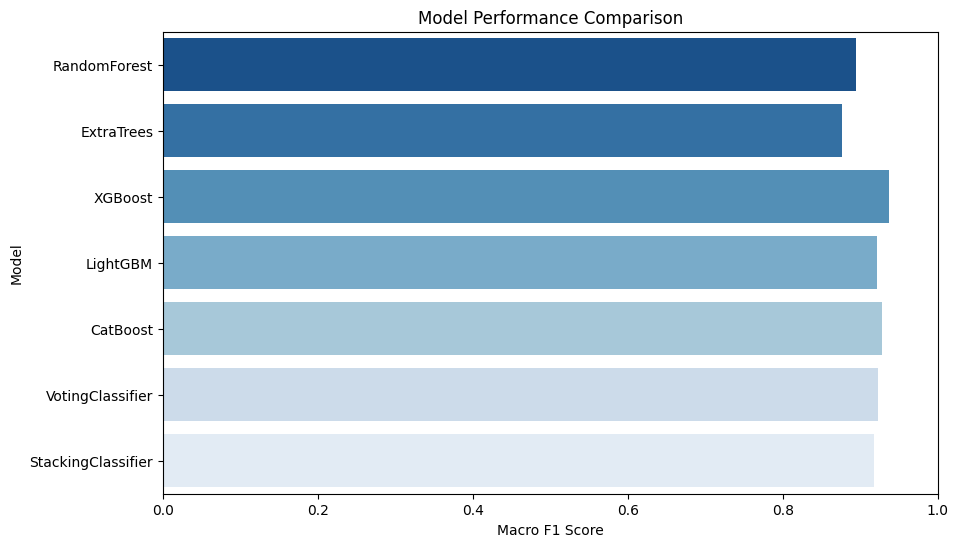

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import joblib

# 🚀 데이터 전처리 모듈 import
from preprocessor import main as DataPreprocessor

# 데이터 전처리 함수
def preprocess_data(data_path, target_column, features):
    raw_data = pd.read_csv(data_path)
    train, _ = DataPreprocessor(raw_data, raw_data)  # train 데이터만 전처리

    # 특성과 타겟 분리
    X = train[features]
    y = train[target_column]

    # 데이터 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler


# ✅ **Optuna를 사용한 XGBoost 하이퍼파라미터 최적화**
def optimize_xgb(X, y, n_trials=20):
    def objective(trial):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
        }
        model = XGBClassifier(**params, eval_metric="logloss", enable_categorical=False, n_jobs=-1)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return f1_score(y_test, y_pred, average="macro")

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params


# ✅ **Optuna를 사용한 LightGBM 하이퍼파라미터 최적화**
def optimize_lgbm(X, y, n_trials=20):
    def objective(trial):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
        }
        model = LGBMClassifier(**params)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return f1_score(y_test, y_pred, average="macro")

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params


# ✅ **Optuna를 사용한 CatBoost 하이퍼파라미터 최적화**
def optimize_catboost(X, y, n_trials=20):
    def objective(trial):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        params = {
            "iterations": trial.suggest_int("iterations", 500, 2000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "early_stopping_rounds": 50,
            "verbose": 0
        }
        model = CatBoostClassifier(**params, loss_function="Logloss", eval_metric="F1")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return f1_score(y_test, y_pred, average="macro")

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params


# ✅ **모델 정의 함수 (CatBoost 추가)**
def define_models(X, y):
    best_xgb_params = optimize_xgb(X, y)
    best_lgbm_params = optimize_lgbm(X, y)
    best_cat_params = optimize_catboost(X, y)

    base_models = {
        "RandomForest": RandomForestClassifier(random_state=42, n_estimators=300, class_weight="balanced"),
        "ExtraTrees": ExtraTreesClassifier(random_state=42, n_estimators=300, class_weight="balanced"),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss', **best_xgb_params),
        "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced", verbosity=-1, **best_lgbm_params),
        "CatBoost": CatBoostClassifier(random_state=42, verbose=0, **best_cat_params)
    }
    return base_models


# VotingClassifier 생성 함수
def get_voting_classifier(models):
    return VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')


# StackingClassifier 생성 함수
def get_stacking_classifier(models):
    return StackingClassifier(estimators=[(name, model) for name, model in models.items()], final_estimator=LogisticRegression())


# 모델 학습 및 평가
def train_and_evaluate_models(models, X, y, test_size=0.2):
    results = []
    best_model = None
    best_f1 = 0

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        macro_f1 = f1_score(y_test, y_pred, average="macro")

        results.append({"Model": name, "Macro F1 Score": macro_f1})

        if macro_f1 > best_f1:
            best_f1 = macro_f1
            best_model = model

    results_df = pd.DataFrame(results)
    return results_df, best_model


# 모델 학습 및 저장
def train_and_save_model(data_path, target_column, features, model_save_path, scaler_save_path):
    X, y, scaler = preprocess_data(data_path, target_column, features)

    # 모델 정의
    models = define_models(X, y)

    # Voting & Stacking 모델 추가
    models["VotingClassifier"] = get_voting_classifier(models)
    models["StackingClassifier"] = get_stacking_classifier(models)

    # Stratified K-Fold 평가
    results_df, best_model = train_and_evaluate_models(models, X, y)

    # 최적 모델 저장
    best_model.fit(X, y)
    joblib.dump(best_model, model_save_path)
    joblib.dump(scaler, scaler_save_path)

    print(f"Best model: {best_model.__class__.__name__}")
    print(f"Best model saved to {model_save_path}")

    return results_df, best_model.__class__.__name__


# 모델 성능 시각화
def visualize_model_performance(results_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x="Macro F1 Score", y="Model", palette="Blues_r")
    plt.xlabel("Macro F1 Score")
    plt.ylabel("Model")
    plt.title("Model Performance Comparison")
    plt.xlim(0, 1)
    plt.show()


# 실행
if __name__ == "__main__":
    data_path = "data/train.csv"
    target_column = "허위매물여부"
    model_save_path = "model_list/ML/model/model_t_20.joblib"
    scaler_save_path = "model_list/ML/scaler/scaler_t_20.joblib"

    features = ['보증금', '월세', '총층', '주차가능여부', '관리비', '제공플랫폼', 
                '전용면적_결측치_여부', '해당층_결측치_여부', 'G52중개사무소여부', 
                '게재연', '게재월', '게재분기']

    results, best_model_name = train_and_save_model(data_path, target_column, features, model_save_path, scaler_save_path)
    visualize_model_performance(results)